In [1]:
#==================================
# BLOCK 1 - FNO Implementation
#==================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.fft import rfft2, irfft2

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#==================================
# BLOCK 2 - FNO Architecture
#==================================

class SpectralConv2d(nn.Module):
    """2D Fourier layer. Performs FFT, linear transform, and Inverse FFT."""
    
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to keep in x
        self.modes2 = modes2  # Number of Fourier modes to keep in z
        
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        
    def compl_mul2d(self, input, weights):
        # Complex multiplication
        return torch.einsum("bixy,ioxy->boxy", input, weights)
    
    def forward(self, x):
        batchsize = x.shape[0]
        
        # Compute Fourier coefficients
        x_ft = rfft2(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        # Top-left corner (low frequencies)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        
        # Bottom-left corner (high frequencies in z, low in x)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        
        # Return to physical space
        x = irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNOBlock(nn.Module):
    """Basic FNO block with spectral convolution and skip connection"""
    
    def __init__(self, in_channels, out_channels, modes1, modes2, activation='gelu'):
        super(FNOBlock, self).__init__()
        self.conv = SpectralConv2d(in_channels, out_channels, modes1, modes2)
        self.w = nn.Conv2d(in_channels, out_channels, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        
        if activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
    
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.w(x)
        x = self.bn(x1 + x2)
        x = self.activation(x)
        return x

class FNO2d(nn.Module):
    """
    Fourier Neural Operator for 2D problems
    Adapted for predicting buoyancy from initial conditions and target velocities
    """
    
    def __init__(self, modes1=24, modes2=24, width=64, in_channels=6, out_channels=1, n_layers=4):
        super(FNO2d, self).__init__()
        
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_layers = n_layers
        
        # Input projection (6 channels: u_init, w_init, b_init, p_init, u_target, w_target)
        self.fc0 = nn.Sequential(
            nn.Conv2d(in_channels, width, 1),
            nn.GELU(),
            nn.Conv2d(width, width, 1),
        )
        
        # FNO layers
        self.fno_blocks = nn.ModuleList([
            FNOBlock(width, width, modes1, modes2, activation='gelu')
            for _ in range(n_layers)
        ])
        
        # Final projection to output
        self.fc1 = nn.Sequential(
            nn.Conv2d(width, 128, 1),
            nn.GELU(),
            nn.Conv2d(128, 64, 1),
            nn.GELU(),
            nn.Conv2d(64, out_channels, 1)
        )
        
    def forward(self, x):
        # x shape: (batch, channels, height, width)
        
        # Lift to higher dimension
        x = self.fc0(x)
        
        # Apply FNO blocks
        for fno in self.fno_blocks:
            x = fno(x)
        
        # Project to output
        x = self.fc1(x)
        
        return x.squeeze(1)  # Remove channel dimension for single output

#==================================
# BLOCK 3 - Enhanced FNO with Time Embedding
#==================================

class TimeFNO2d(nn.Module):
    """
    FNO with explicit time embedding for better temporal awareness
    """
    
    def __init__(self, modes1=24, modes2=24, width=64, in_channels=6, out_channels=1, 
                 n_layers=4, time_dim=32):
        super(TimeFNO2d, self).__init__()
        
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_layers = n_layers
        self.time_dim = time_dim
        
        # Time embedding network
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, width)
        )
        
        # Input projection
        self.fc0 = nn.Sequential(
            nn.Conv2d(in_channels, width, 1),
            nn.GELU(),
            nn.Conv2d(width, width, 1),
        )
        
        # FNO layers with time modulation
        self.fno_blocks = nn.ModuleList([
            FNOBlock(width, width, modes1, modes2, activation='gelu')
            for _ in range(n_layers)
        ])
        
        # Time modulation layers
        self.time_mod = nn.ModuleList([
            nn.Conv2d(width, width, 1)
            for _ in range(n_layers)
        ])
        
        # Final projection
        self.fc1 = nn.Sequential(
            nn.Conv2d(width, 128, 1),
            nn.GELU(),
            nn.Conv2d(128, 64, 1),
            nn.GELU(),
            nn.Conv2d(64, out_channels, 1)
        )
        
    def forward(self, x, t):
        # x shape: (batch, channels, height, width)
        # t shape: (batch, 1)
        
        # Get time embedding
        t_emb = self.time_mlp(t)  # (batch, width)
        
        # Lift to higher dimension
        x = self.fc0(x)
        
        # Apply FNO blocks with time modulation
        for i, (fno, t_mod) in enumerate(zip(self.fno_blocks, self.time_mod)):
            # FNO operation
            x_fno = fno(x)
            
            # Time modulation
            t_scale = t_emb.unsqueeze(-1).unsqueeze(-1)  # (batch, width, 1, 1)
            x_t = t_mod(x) * t_scale
            
            # Combine
            x = x_fno + x_t
        
        # Project to output
        x = self.fc1(x)
        
        return x.squeeze(1)

#==================================
# BLOCK 4 - Data Preparation for FNO
#==================================

# Load and prepare data (using your existing code)
ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')

# Select time steps
time_idx = 30
X_init = ds.isel(time=time_idx)
X_target = ds.isel(time=time_idx + 100)

# Extract time information
dt = float((X_target.time - X_init.time) / np.timedelta64(1, 's'))
print(f"Time step size: {dt} seconds")

# Extract fields
u_init = X_init['u'].values
w_init = X_init['w'].values
b_init = X_init['b'].values
p_dyn_init = X_init['p_dyn'].values

u_target = X_target['u'].values
w_target = X_target['w'].values
b_target = X_target['b'].values

# Interpolate to common grid
def interpolate_to_common_grid(field, target_shape=(256, 256)):
    if field.shape == target_shape:
        return field
    field_tensor = torch.from_numpy(field).float().unsqueeze(0).unsqueeze(0)
    interpolated = F.interpolate(field_tensor, size=target_shape, mode='bilinear', align_corners=True)
    return interpolated.squeeze().numpy()

u_init_interp = interpolate_to_common_grid(u_init)
w_init_interp = interpolate_to_common_grid(w_init)
u_target_interp = interpolate_to_common_grid(u_target)
w_target_interp = interpolate_to_common_grid(w_target)
p_dyn_init_interp = interpolate_to_common_grid(p_dyn_init)

# Normalize fields
def normalize_field(field):
    mean = np.mean(field)
    std = np.std(field) + 1e-8
    return (field - mean) / std, mean, std

# Normalize all fields
u_init_norm, u_init_mean, u_init_std = normalize_field(u_init_interp)
w_init_norm, w_init_mean, w_init_std = normalize_field(w_init_interp)
b_init_norm, b_mean, b_std = normalize_field(b_init)
p_init_norm, p_mean, p_std = normalize_field(p_dyn_init_interp)
u_target_norm, u_target_mean, u_target_std = normalize_field(u_target_interp)
w_target_norm, w_target_mean, w_target_std = normalize_field(w_target_interp)

# Store normalization parameters
norm_params = {
    'b': (b_mean, b_std),
    'u_target': (u_target_mean, u_target_std),
    'w_target': (w_target_mean, w_target_std),
}

# Prepare input tensor for FNO
# Stack all input fields: u_init, w_init, b_init, p_init, u_target, w_target
input_fields = np.stack([
    u_init_norm, 
    w_init_norm, 
    b_init_norm, 
    p_init_norm,
    u_target_norm,
    w_target_norm
], axis=0)

input_tensor = torch.FloatTensor(input_fields).unsqueeze(0).to(device)
b_init_tensor = torch.FloatTensor(b_init_norm).unsqueeze(0).to(device)
b_target_tensor = torch.FloatTensor(b_target).unsqueeze(0).to(device)
dt_tensor = torch.FloatTensor([[dt]]).to(device)

# Grid parameters
x_coords = X_init.x_caa.values
z_coords = X_init.z_aac.values
dx = float(x_coords[1] - x_coords[0])
dz = float(z_coords[1] - z_coords[0])
kappa = 1e-6

print(f"Input tensor shape: {input_tensor.shape}")
print(f"Grid spacing: dx={dx:.6f}, dz={dz:.6f}")

#==================================
# BLOCK 5 - Training FNO (continued)
#==================================

# Initialize FNO model
model = TimeFNO2d(
    modes1=32,      # Fourier modes in x
    modes2=32,      # Fourier modes in z  
    width=64,       # Channel width
    in_channels=6,  # u_init, w_init, b_init, p_init, u_target, w_target
    out_channels=1, # b prediction
    n_layers=4,     # Number of FNO blocks
    time_dim=32     # Time embedding dimension
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in FNO: {total_params:,}")

# Define physics-informed loss functions
def compute_derivatives_fno(field, dx, dz):
    """Compute spatial derivatives using finite differences"""
    if field.dim() == 2:
        field = field.unsqueeze(0)
    
    # Pad for periodic BC in x
    field_padded_x = F.pad(field.unsqueeze(1), (1, 1, 0, 0), mode='circular').squeeze(1)
    df_dx = (field_padded_x[:, :, 2:] - field_padded_x[:, :, :-2]) / (2 * dx)
    
    # z-derivatives
    df_dz = torch.zeros_like(field)
    df_dz[:, 1:-1, :] = (field[:, 2:, :] - field[:, :-2, :]) / (2 * dz)
    df_dz[:, 0, :] = (field[:, 1, :] - field[:, 0, :]) / dz
    df_dz[:, -1, :] = (field[:, -1, :] - field[:, -2, :]) / dz
    
    return df_dx, df_dz

def physics_loss_fno(b_pred_norm, u_target_tensor, w_target_tensor, b_init_tensor, 
                     dx, dz, dt, kappa, norm_params):
    """Physics-informed loss for FNO"""
    # Denormalize
    b_mean, b_std = norm_params['b']
    u_mean, u_std = norm_params['u_target']
    w_mean, w_std = norm_params['w_target']
    
    b_pred = b_pred_norm * b_std + b_mean
    b_init = b_init_tensor * b_std + b_mean
    u = u_target_tensor * u_std + u_mean
    w = w_target_tensor * w_std + w_mean
    
    # Compute derivatives
    db_dx, db_dz = compute_derivatives_fno(b_pred, dx, dz)
    d2b_dx2, _ = compute_derivatives_fno(db_dx, dx, dz)
    _, d2b_dz2 = compute_derivatives_fno(db_dz, dx, dz)
    
    # Time derivative
    db_dt = (b_pred - b_init) / dt
    
    # Advection-diffusion equation
    advection = u * db_dx + w * db_dz
    diffusion = kappa * (d2b_dx2 + d2b_dz2)
    residual = db_dt + advection - diffusion
    
    return torch.mean(residual**2)

def boundary_loss_fno(b_pred_norm, norm_params):
    """Boundary condition loss"""
    b_mean, b_std = norm_params['b']
    b_pred = b_pred_norm * b_std + b_mean
    
    top_bc = torch.mean((b_pred[:, -1, :] - 0.5)**2)
    bottom_bc = torch.mean((b_pred[:, 0, :])**2)
    
    return top_bc + bottom_bc

def smoothness_loss_fno(b_pred):
    """Total variation regularization"""
    tv_z = torch.mean(torch.abs(b_pred[:, 1:, :] - b_pred[:, :-1, :]))
    tv_x = torch.mean(torch.abs(b_pred[:, :, 1:] - b_pred[:, :, :-1]))
    return tv_z + tv_x

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1e-3,
    epochs=2000,
    steps_per_epoch=1,
    pct_start=0.1,
    anneal_strategy='cos'
)

#==================================
# BLOCK 6 - Training Loop for FNO
#==================================

# Loss weights
loss_weights = {
    'physics': 1.0,
    'bc': 50.0,
    'data': 10.0,
    'smooth': 0.0
}

# Prepare velocity tensors
u_target_tensor_norm = torch.FloatTensor(u_target_norm).unsqueeze(0).to(device)
w_target_tensor_norm = torch.FloatTensor(w_target_norm).unsqueeze(0).to(device)

# Training history
history = {
    'total_loss': [],
    'physics_loss': [],
    'bc_loss': [],
    'data_loss': [],
    'smooth_loss': []
}

Using device: cuda


/tmp/ipykernel_36/1370024042.py:228: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')


Time step size: 50.0 seconds
Input tensor shape: torch.Size([1, 6, 256, 256])
Grid spacing: dx=0.007812, dz=0.003906
Total parameters in FNO: 33,612,705


Starting FNO training...
Epoch 0/1400 | Total: 175.015915 | Physics: 0.749420 | BC: 3.340310 | Data: 0.725101 | LR: 0.000040
Epoch 100/1400 | Total: 0.097310 | Physics: 0.004071 | BC: 0.001652 | Data: 0.001066 | LR: 0.000531
Epoch 200/1400 | Total: 0.148934 | Physics: 0.001143 | BC: 0.002685 | Data: 0.001352 | LR: 0.001000
Epoch 300/1400 | Total: 0.092730 | Physics: 0.000791 | BC: 0.001578 | Data: 0.001302 | LR: 0.000992
Epoch 400/1400 | Total: 0.046695 | Physics: 0.000224 | BC: 0.000823 | Data: 0.000532 | LR: 0.000969
Epoch 500/1400 | Total: 0.025838 | Physics: 0.000197 | BC: 0.000429 | Data: 0.000419 | LR: 0.000932
Epoch 600/1400 | Total: 0.009599 | Physics: 0.000159 | BC: 0.000113 | Data: 0.000379 | LR: 0.000882
Epoch 700/1400 | Total: 0.009603 | Physics: 0.000149 | BC: 0.000114 | Data: 0.000374 | LR: 0.000820
Epoch 800/1400 | Total: 0.003587 | Physics: 0.000147 | BC: 0.000000 | Data: 0.000344 | LR: 0.000748
Epoch 900/1400 | Total: 0.003556 | Physics: 0.000140 | BC: 0.000000 | Data:

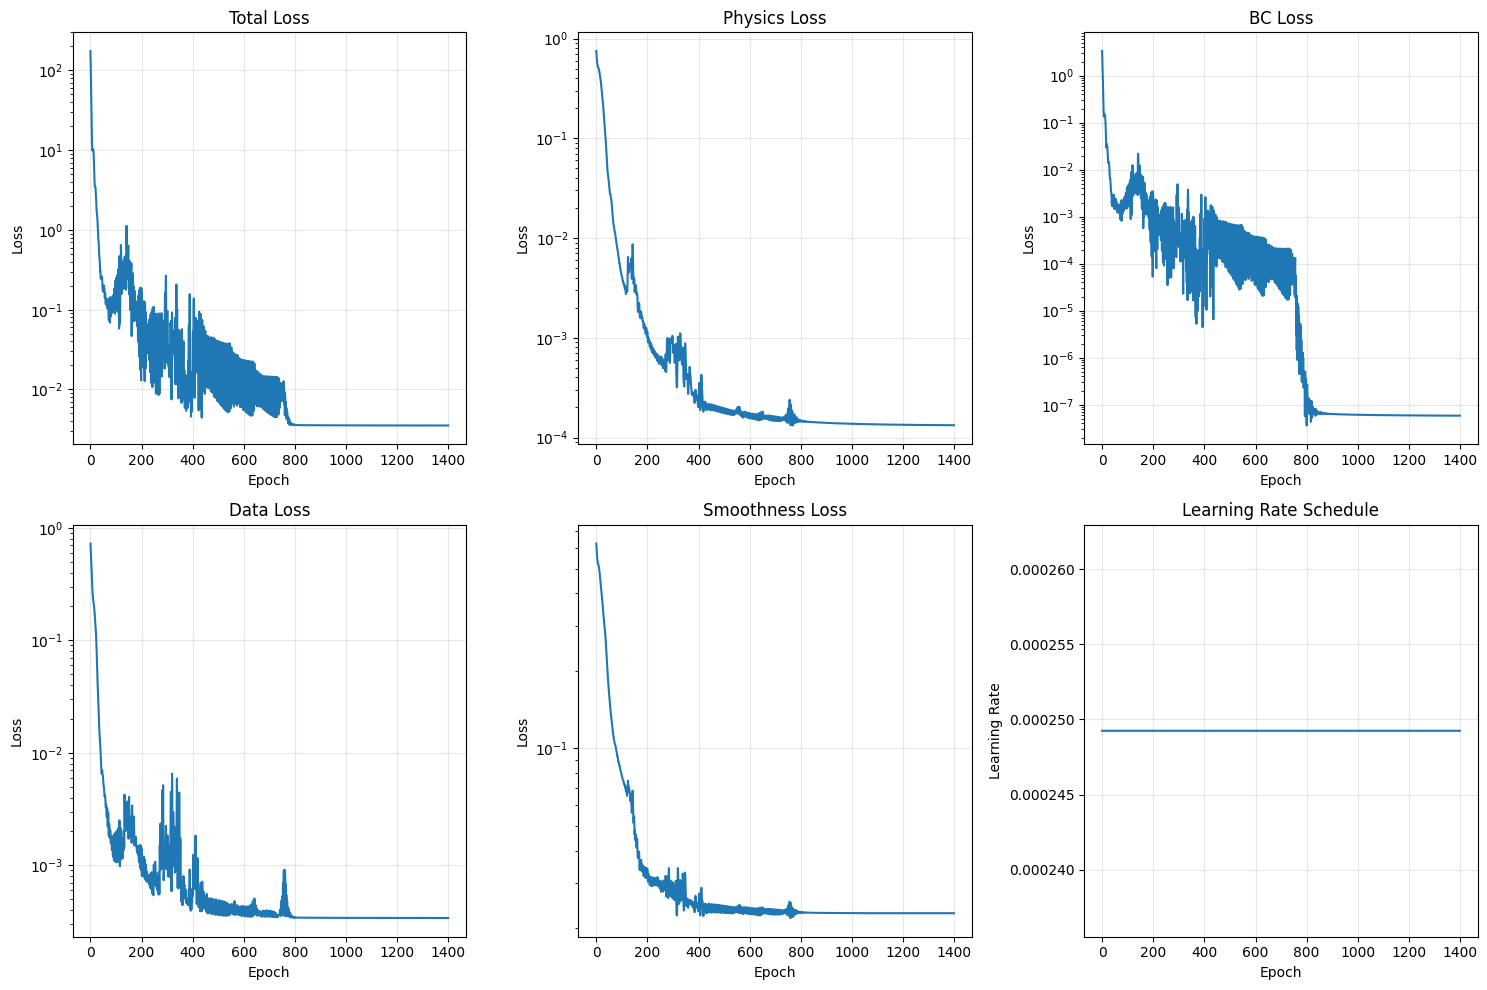

In [2]:
# Training
model.train()
n_epochs = 1400
print_interval = 100

print("Starting FNO training...")
best_loss = float('inf')

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    b_pred_norm = model(input_tensor, dt_tensor)
    
    # Compute losses
    l_physics = physics_loss_fno(
        b_pred_norm, u_target_tensor_norm, w_target_tensor_norm, 
        b_init_tensor, dx, dz, dt, kappa, norm_params
    )
    
    l_bc = boundary_loss_fno(b_pred_norm, norm_params)
    
    # Data fitting loss (comparing with target in physical space)
    b_pred_denorm = b_pred_norm * b_std + b_mean
    l_data = torch.mean((b_pred_denorm - b_target_tensor)**2)
    
    l_smooth = smoothness_loss_fno(b_pred_norm)
    
    # Total loss
    total_loss = (
        loss_weights['physics'] * l_physics +
        loss_weights['bc'] * l_bc +
        loss_weights['data'] * l_data +
        loss_weights['smooth'] * l_smooth
    )
    
    # Backward pass
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    scheduler.step()
    
    # Record history
    history['total_loss'].append(total_loss.item())
    history['physics_loss'].append(l_physics.item())
    history['bc_loss'].append(l_bc.item())
    history['data_loss'].append(l_data.item())
    history['smooth_loss'].append(l_smooth.item())
    
    # Adaptive weight adjustment
    if epoch > 500 and epoch % 200 == 0:
        if l_physics.item() > 0.1:
            loss_weights['physics'] = min(loss_weights['physics'] * 1.2, 10.0)
        if l_bc.item() > 0.01:
            loss_weights['bc'] = min(loss_weights['bc'] * 1.1, 100.0)
    
    # Save best model
    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        best_model_state = model.state_dict().copy()
    
    # Print progress
    if epoch % print_interval == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch}/{n_epochs} | Total: {total_loss.item():.6f} | "
              f"Physics: {l_physics.item():.6f} | BC: {l_bc.item():.6f} | "
              f"Data: {l_data.item():.6f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# Load best model
model.load_state_dict(best_model_state)

#==================================
# BLOCK 7 - Plot Training History
#==================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

loss_names = ['total_loss', 'physics_loss', 'bc_loss', 'data_loss', 'smooth_loss']
loss_titles = ['Total Loss', 'Physics Loss', 'BC Loss', 'Data Loss', 'Smoothness Loss']

for idx, (loss_name, title) in enumerate(zip(loss_names, loss_titles)):
    ax = axes[idx]
    ax.semilogy(history[loss_name])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# Learning rate schedule
ax = axes[5]
lrs = [scheduler.get_last_lr()[0] for _ in range(len(history['total_loss']))]
ax.plot(lrs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

FNO Prediction shape: (256, 256)
FNO Prediction range: [-0.0002, 0.8757]
Target range: [0.0018, 0.8653]


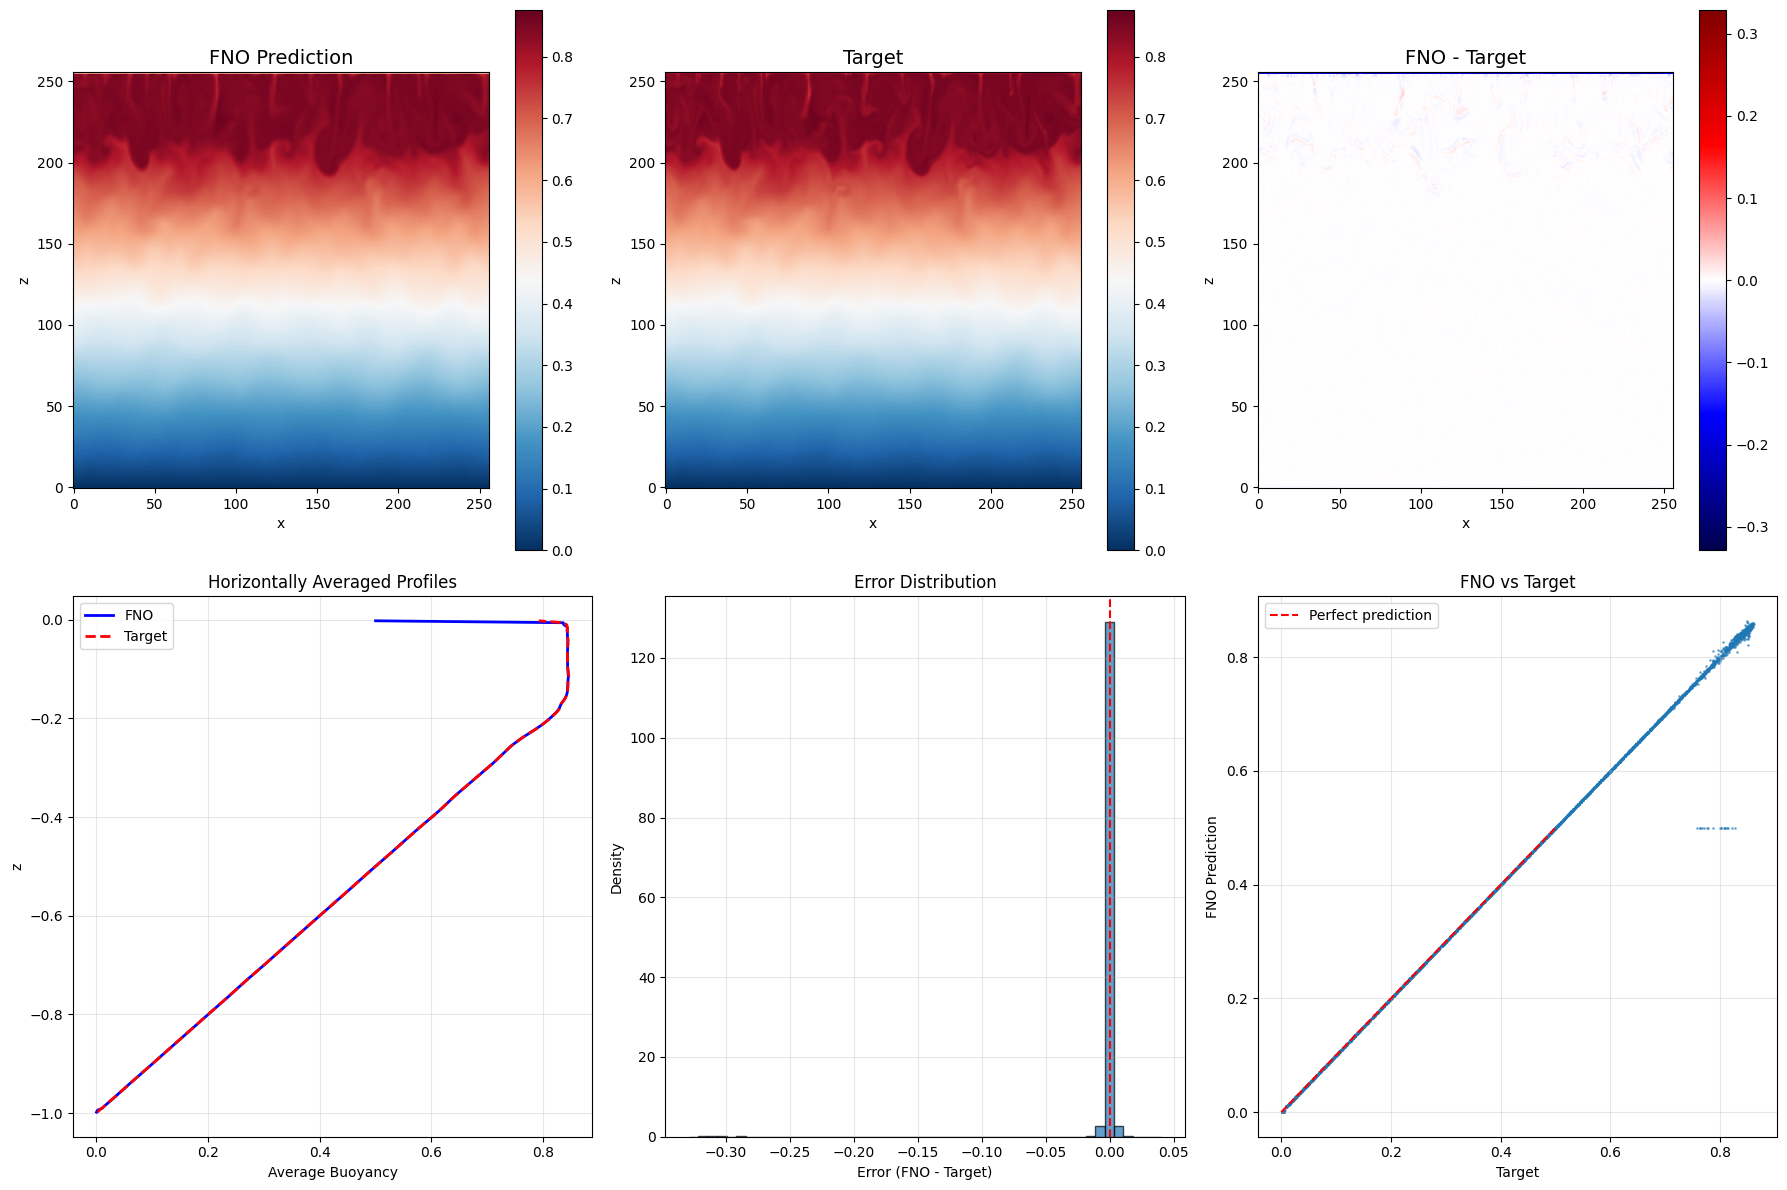


FNO Error Metrics:
MSE: 0.000340
MAE: 0.001958
Max Error: 0.328871
Relative Error: 1.0183%


In [3]:
#==================================
# BLOCK 8 - Evaluation and Comparison
#==================================

# Make prediction with FNO
model.eval()
with torch.no_grad():
    b_pred_fno_norm = model(input_tensor, dt_tensor)
    b_pred_fno_norm = b_pred_fno_norm.squeeze().cpu().numpy()

# Denormalize
b_pred_fno = b_pred_fno_norm * b_std + b_mean

print(f"FNO Prediction shape: {b_pred_fno.shape}")
print(f"FNO Prediction range: [{b_pred_fno.min():.4f}, {b_pred_fno.max():.4f}]")
print(f"Target range: [{b_target.min():.4f}, {b_target.max():.4f}]")

# Create comparison plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Common colorbar limits
vmin = min(b_pred_fno.min(), b_target.min())
vmax = max(b_pred_fno.max(), b_target.max())

# Row 1: Fields
# FNO Prediction
im1 = axes[0, 0].imshow(b_pred_fno, aspect='equal', cmap='RdBu_r', 
                        vmin=vmin, vmax=vmax, origin='lower')
axes[0, 0].set_title('FNO Prediction', fontsize=14)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0, 0])

# Target
im2 = axes[0, 1].imshow(b_target, aspect='equal', cmap='RdBu_r', 
                        vmin=vmin, vmax=vmax, origin='lower')
axes[0, 1].set_title('Target', fontsize=14)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('z')
plt.colorbar(im2, ax=axes[0, 1])

# Difference
diff_fno = b_pred_fno - b_target
im3 = axes[0, 2].imshow(diff_fno, aspect='equal', cmap='seismic', 
                        vmin=-np.abs(diff_fno).max(), vmax=np.abs(diff_fno).max(), 
                        origin='lower')
axes[0, 2].set_title('FNO - Target', fontsize=14)
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('z')
plt.colorbar(im3, ax=axes[0, 2])

# Row 2: Profiles and error analysis
# Horizontally averaged profiles
ax = axes[1, 0]
avg_b_fno = np.mean(b_pred_fno, axis=1)
avg_b_target = np.mean(b_target, axis=1)
ax.plot(avg_b_fno, z_coords, 'b-', linewidth=2, label='FNO')
ax.plot(avg_b_target, z_coords, 'r--', linewidth=2, label='Target')
ax.set_xlabel('Average Buoyancy')
ax.set_ylabel('z')
ax.set_title('Horizontally Averaged Profiles')
ax.legend()
ax.grid(True, alpha=0.3)

# Error distribution
ax = axes[1, 1]
errors = (b_pred_fno - b_target).flatten()
ax.hist(errors, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.set_xlabel('Error (FNO - Target)')
ax.set_ylabel('Density')
ax.set_title('Error Distribution')
ax.axvline(x=0, color='r', linestyle='--', label='Zero error')
ax.grid(True, alpha=0.3)

# Scatter plot
ax = axes[1, 2]
sample_indices = np.random.choice(b_pred_fno.size, 5000, replace=False)
ax.scatter(b_target.flatten()[sample_indices], 
           b_pred_fno.flatten()[sample_indices], 
           alpha=0.5, s=1)
ax.plot([0, 0.5], [0, 0.5], 'r--', label='Perfect prediction')
ax.set_xlabel('Target')
ax.set_ylabel('FNO Prediction')
ax.set_title('FNO vs Target')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate error metrics
mse_fno = np.mean((b_pred_fno - b_target)**2)
mae_fno = np.mean(np.abs(b_pred_fno - b_target))
max_error_fno = np.max(np.abs(b_pred_fno - b_target))
rel_error_fno = np.mean(np.abs(b_pred_fno - b_target) / (np.abs(b_target) + 1e-8))

print(f"\nFNO Error Metrics:")
print(f"MSE: {mse_fno:.6f}")
print(f"MAE: {mae_fno:.6f}")
print(f"Max Error: {max_error_fno:.6f}")
print(f"Relative Error: {rel_error_fno:.4%}")